## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  A/B test is an experiment where two or more variants of a web-page are shown to users at random and statistical analysis is used to determine the variants which best fits the conversion goal. the variants may defer from small changes to major or multiple changes in layout.

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Here we read in our dataset 'ab_data.csv' and have a first look at our data.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null datetime64[ns]
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


Converted the column 'timestamp' from object/string to timestamp format.

b. Use the cell below to find the number of rows in the dataset.

In [6]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [7]:
df['user_id'].nunique()

290584

In [8]:
df.duplicated().sum()

0

d. The proportion of users converted.

In [9]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [10]:
a = df.query('landing_page == "new_page" and group != "treatment"').count()
b = df.query('landing_page == "old_page" and group != "control"').count()
a+b

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [11]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Here we are filtering out the rows where group and landing_page match appropriately to the test.

In [12]:
df2 = df.query('(group == "treatment" and landing_page == "new_page") or\
                (group == "control" and landing_page == "old_page")')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [14]:
a = df2.query('landing_page == "new_page" and group != "treatment"').count()
b = df2.query('landing_page == "old_page" and group != "control"').count()
a+b

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. There was a mismatch in the total number of rows and uniques rows. This is due to the repeated user-ids'. Duplicated() did not pick this this up due to mismatch of timestamp. Some of these rows would have been dropped with the mismatched group and landing_page data. 

Next, we will filter out repeated user-ids.

In [15]:
df2['user_id'].nunique()

290584

In [16]:
df2.shape

(290585, 5)

b. There is one **user_id** repeated in **df2**.  

In [17]:
df2['user_id'].value_counts().idxmax()

773192

c. What is the row information for the repeat **user_id**? 

In [18]:
df2[df2['user_id'] == df2['user_id'].value_counts().idxmax()]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. On Both attempts the user was directed to the new page and did not convert. Hence we can drop any one of these two rows and it would not affect the analysis.

In [19]:
df2.drop(1899, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


`4.` a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
p_cont_convert = df2.query('group == "control"')['converted'].mean()
p_cont_convert

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
p_treat_convert = df2.query('group == "treatment"')['converted'].mean()
p_treat_convert

0.11880806551510564

In [23]:
abs_diff = p_treat_convert - p_cont_convert
abs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [24]:
(df['landing_page'] == "new_page").mean()

0.5

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

The proportion of new and old pages is equal. The probability of conversion for the pages is almost equal. Although the probabiblity of conversion for old page is slightly higher than the new page. The above results are not fit for any solid conclusion.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**The null hypothesis is that the conversion rate for the new page is less than or equal to the old page.**

**Alternative hypothesis is that the conversion rate for the new page is more than the old page.**

### Null Hypothesis:
                     H0:   pnew - pold <= 0
### Alternate Hypothesis:                        
                     H1:   pnew - pold > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Next, We will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>
  

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [25]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [26]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [27]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [28]:
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [29]:
new_page_conerted = np.random.choice([0,1], size= n_new, p= [1-p_new,p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [30]:
old_page_converted = np.random.choice([0,1], size= n_old, p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [31]:
new_page_conerted.mean() - old_page_converted.mean()

0.0033358987274445806

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [32]:
p_diffs = []
for _ in range(10000):
    sample_new = np.random.binomial(1, p = p_new, size=n_new)
    sample_old = np.random.binomial(1, p = p_old, size=n_old)
    p_diffs.append(sample_new.mean() - sample_old.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

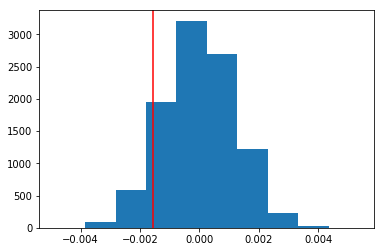

In [33]:
plt.hist(p_diffs)
plt.axvline(abs_diff, color='r');

**The plot is normally distributed around zero.As per the Law of large numbers and Central Limit Theorem, the plot should be normally distributed centred around zero.**
From the first look, our data difference(abs_diff) is close to the mean difference on the left. And for a right tailed hypothesis, It suggests the null is actually true. We will confirm that by calculating the p-value.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
p_diff_mean = np.array(p_diffs).mean()
p_diff_mean

-5.501519051968051e-07

In [35]:
p_value = (p_diffs > abs_diff).mean()
p_value

0.90500000000000003

In [36]:
np.std(p_diffs)

0.0011993429374219486

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Actual difference is the difference in the conversion rates of the new page and old page from the dataset.**

We have simulated a sampling distribution for the mean difference. p_value is the probability of observing our statistic or one or more extreme in the favor of the alternative. 

p-value is greater than the type-I error threshold of 5%. Therefore we fail to reject the Null Hypothesis.



l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('group == "control"')['user_id'].count()
n_new = df2.query('group == "treatment"')['user_id'].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [38]:
stat,pval = sm.stats.proportions_ztest(count=[convert_new,convert_old],nobs=[n_new,n_old], alternative='larger')
stat, pval

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Z-Score is the number of standard deviations a data point is apart from the mean.**
In the histogram above, actual difference lies to the left of the mean difference. It is confirmed by the negative z-score. 

The p-value in z-test is approximately equal to the p-value from hypothesis test above. This high p-value is a strong statistical evidence that we fail to reject the Null.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since the response variable can only have two values either a YES(1) or NO(0). Logistic regression best fits the situation.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
df2['intercept'] = 1
df2[['page1','ab_page']] = pd.get_dummies(df2['group'])
df2.drop('page1', axis=1, inplace=True)
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In the above cell, I have used get_dummies function of pandas to create dummy variable column for the group column which is one when user is directed to new_page. I have added the intercept column for regression.

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [40]:
log_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        13:26:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [41]:
1/np.exp(-1.9888), 1/np.exp(-0.0150)

(7.3067603868728614, 1.0151130646157189)

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

**The negative coefficient of ab_page suggests that it is more likely to get a conversion from the control group/old-page.**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value for ab_page obtained from logistic regression is 0.190. This is lower than the p-value obtained from z-test and simulated process. This is due to the addition of **intercept** and the change in hypothesis.

**The null hypothesis for a logistic regression is that there is no relationship between the explanatory and response variable.**

**The alternative hypothesis for a logistic regression is that a relationship exists between explanatory and response variables.**

                        H0: pnew - pold = 0
                        
                        H1: pnew - pold !=0


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Addition of a relevent variable in the model will cause a bias reduction in the co-efficients estimate.**
I am considering to add the time of the day to the model. Additionally, only if the duration of time spent was available, a more efficient model would be obtained.

In [42]:
df2['hour'] = df2['timestamp'].dt.hour
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,user_id,timestamp,group,landing_page,converted,intercept,ab_page,hour
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,22
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,8
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,16
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,18
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


Here, I have extracted hours from timestamp. Next, I will divide it into 4 parts by dividing the column by 6. Convert it into string/object datatype. Thus there will be 4 values from 0 to 3. Then, by using get_dummies() 4 columns representing: 'morning', 'afternoon', 'evening' and 'night' will be created.

In [43]:
df2['hour'] = (df2['hour']//6).astype(str)
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,user_id,timestamp,group,landing_page,converted,intercept,ab_page,hour
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,3
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,2
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,3
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0


In [44]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 8 columns):
user_id         290584 non-null int64
timestamp       290584 non-null datetime64[ns]
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
hour            290584 non-null object
dtypes: datetime64[ns](1), int64(3), object(3), uint8(1)
memory usage: 18.0+ MB


In [45]:
df2[['morning','afternoon','evening','night']] = pd.get_dummies(df2['hour'])
df2.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,intercept,ab_page,hour,morning,afternoon,evening,night
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,3,0,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,2,0,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,3,0,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1,0,0,0


In [46]:
log_mod2 = sm.Logit(df2['converted'],df2[['intercept','ab_page','afternoon','evening','night']])
result2 = log_mod2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366100
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:               5.793e-05
Time:                        13:26:26   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.01509
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0211      0.013   -156.625      0.000      -2.046      -1.996
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
afternoon      0.0407      0.016      2.502      0.012       0.009       0.073
evening        0.0414      0.016      2.546      0.011       0.010       0.073
night          0.0467      0.016      2.876      0.004       0.015       0.078
==============================================================================
"""

In [47]:
np.exp(0.0407),np.exp(0.0414),np.exp(0.0467)

(1.0415395967924728, 1.0422689297469805, 1.047807619637706)

Time of the day seems to have a positive correlation with conversion. The new page has a negative correlation with conversion and the p-value is above 5%. Therefore, we fail to reject the null.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [48]:
country_df = pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [49]:
country_df.shape

(290584, 2)

df2 = df2.join(country.set_index('user_id'), on='user_id', how='inner')
df2.head()

In [50]:
df2 = df2.set_index('user_id').join(country_df.set_index('user_id'), on='user_id', how='inner')
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,hour,morning,afternoon,evening,night,country
user_id,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,3,0,0,0,1,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,1,0,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,2,0,0,1,0,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,3,0,0,0,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1,0,0,0,US


In [51]:
df2['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [52]:
df2[['ca','uk','us']] = pd.get_dummies(df2['country'])
df2.tail()

,timestamp,group,landing_page,converted,intercept,ab_page,hour,morning,afternoon,evening,night,country,ca,uk,us
user_id,,,,,,,,,,,,,,,
751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,3,0,0,0,1,US,0,0,1
945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,0,1,0,0,0,US,0,0,1
734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,1,0,1,0,0,US,0,0,1
697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,0,1,0,0,0,US,0,0,1
715931,2017-01-16 12:40:24.467417,treatment,new_page,0,1,1,2,0,0,1,0,UK,0,1,0


In [53]:
df2.groupby(['group']).mean()

,converted,intercept,ab_page,morning,afternoon,evening,night,ca,uk,us
group,,,,,,,,,,
control,0.120386,1.0,0.0,0.249418,0.250850,0.248620,0.251112,0.049548,0.250286,0.700167
treatment,0.118808,1.0,1.0,0.250286,0.248717,0.252109,0.248889,0.050244,0.248476,0.701280


In [54]:
log_mod3 = sm.Logit(df2['converted'],df2[['intercept','ab_page','ca','uk']])
result3 = log_mod3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:               2.323e-05
Time:                        13:26:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
ca            -0.0408      0.027     -1.516      0.130      -0.093       0.012
uk             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [55]:
log_mod4 = sm.Logit(df2['converted'],df2[['intercept','ab_page','ca','uk','afternoon','evening','night']])
result4 = log_mod4.fit()
result4.summary()

Optimization terminated successfully.
         Current function value: 0.366095
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            6
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:               7.312e-05
Time:                        13:26:28   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.01633
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0216      0.013   -150.421      0.000      -2.048      -1.995
ab_page       -0.0149      0.011     -1.303      0.193      -0.037       0.008
ca            -0.0408      0.027     -1.516      0.129      -0.093       0.012
uk             0.0099      0.013      0.748      0.455      -0.016       0.036
afternoon      0.0407      0.016      2.506      0.012       0.009       0.073
evening        0.0413      0.016      2.544      0.011       0.009       0.073
night          0.0467      0.016      2.878      0.004       0.015       0.079
==============================================================================
"""

In [56]:
np.exp(result4.params)

intercept    0.132439
ab_page      0.985213
ca           0.960058
uk           1.009991
afternoon    1.041574
evening      1.042180
night        1.047815
dtype: float64

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [57]:
df2['ca_ab_page'] = df2['ca'] * df2['ab_page']
df2['uk_ab_page'] = df2['uk'] * df2['ab_page']
df2.tail()

,timestamp,group,landing_page,converted,intercept,ab_page,hour,morning,afternoon,evening,night,country,ca,uk,us,ca_ab_page,uk_ab_page
user_id,,,,,,,,,,,,,,,,,
751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,3,0,0,0,1,US,0,0,1,0,0
945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,0,1,0,0,0,US,0,0,1,0,0
734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,1,0,1,0,0,US,0,0,1,0,0
697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,0,1,0,0,0,US,0,0,1,0,0
715931,2017-01-16 12:40:24.467417,treatment,new_page,0,1,1,2,0,0,1,0,UK,0,1,0,0,1


In [58]:
log_mod5 = sm.Logit(df2['converted'],df2[['intercept','ab_page','ca','uk','ca_ab_page','uk_ab_page','afternoon','evening','night']])
result5 = log_mod5.fit()
result5.summary()

Optimization terminated successfully.
         Current function value: 0.366090
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290575
Method:                           MLE   Df Model:                            8
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:               8.475e-05
Time:                        13:26:30   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.02099
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0188      0.014   -144.886      0.000      -2.046      -1.992
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
ca            -0.0176      0.038     -0.468      0.640      -0.091       0.056
uk            -0.0058      0.019     -0.307      0.759      -0.043       0.031
ca_ab_page    -0.0467      0.054     -0.868      0.385      -0.152       0.059
uk_ab_page     0.0315      0.027      1.186      0.235      -0.021       0.084
afternoon      0.0408      0.016      2.510      0.012       0.009       0.073
evening        0.0413      0.016      2.541      0.011       0.009       0.073
night          0.0467      0.016      2.880      0.004       0.015       0.079
==============================================================================
"""

The p-value for ab_page came down to 0.132 which is still more than the Type I error rate of 5%. The R-squared value increased by a small amount. New page has a negative correlation with conversion. We fail to reject the Null.

There is only a certain amount that a variable can contribute to a model. From the data available, we fail to reject the null. There are other plausible factors that can be of use here. For eg, Duration of time spent on site ,Existing/New user, Age, Sex, etc. could be valuable data for our test. Overall, Old page proved to be better in all our tests. 

<a id='conclusions'></a>
## Conclusion

All the above models, prove that new page has a negative correlation with conversion. A person from UK browsing at night directed to old page is more likely to convert than a person from CA browsing in morning and directed to new page.

The p-value for ab_page is more than the 5% type I error rate and coefficient suggests negative correlation with conversion. old page is likely to receive more conversions than new page. We fail to reject the Null Hypothesis.
Statistically old page is better and there seems no practical significance to roll out the new page.

Company should continue with the existing/old page.

## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [59]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0